# EcoLogic

#### Dependencies

In [34]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import yaml
import os
import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda
import mnist_dataset
from hydra import initialize, compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from difflogic import LogicLayer, GroupSum
from mnist_dataset import MNISTRemoveBorderTransform

#### Dataset

Tunable Variables

In [2]:
# Configurable options
remove_border = True       # True: Removes border of Mnist, False: Keeps black border around digits
binarize_images = True     # True: Binarized Images, False: Grayscale Images 
evenly_partitioned = True  # True: Even distribution of samples, False: Original Mnist distribution
upscaled_images = False    # True: Upscales the samples to 32x32, False: Keeps size unchanged
downscaled_images = True   # True: Downscales the samples to 16x16, False: Keeps size unchanged
batch_size = 256           # Batch size

Dataset Transform

In [3]:
# function to binarize an image, threshold is tunable 
def binarize(image, threshold=0.5):
    return (image > threshold).float()  

# define the transformation logic based on the toggle
transform_list = [ToTensor()]

if remove_border:
    transform_list.append(MNISTRemoveBorderTransform())
    
if upscaled_images:
    transform_list.append(Resize((32, 32)))
elif downscaled_images:
    transform_list.append(Resize((16, 16)))
if binarize_images:
    transform_list.append(Lambda(lambda x: binarize(x)))
    
# adds binarization if enabled
if binarize_images:
    transform_list.append(Lambda(lambda x: binarize(x)))
    
transform = Compose(transform_list)

In [4]:
train_dataset = mnist_dataset.MNIST('./data-mnist', train=True, download=True, transform=transform)
test_dataset = mnist_dataset.MNIST('./data-mnist', train=False, transform=transform)

# drop_last = True means it will drop the last incomplete Batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [5]:
# makes the Dataset evenly partitioned
if evenly_partitioned:
    # code below is used so that all classes have the same number of samples
    train_targets = train_loader.dataset.targets
    test_targets = test_loader.dataset.targets

    train_digits_total = []
    test_digits_total = []

    for i in range(10):
        curr_tot_train = torch.sum(train_targets == i).item()
        curr_tot_test = torch.sum(test_targets == i).item()    
        train_digits_total.append(curr_tot_train)
        test_digits_total.append(curr_tot_test)

    train_digits_total, test_digits_total

    # find the minimum number of samples across all classes
    min_samples_train = min(train_digits_total)
    min_samples_test = min(test_digits_total)

    # function to trim dataset to match the minimum samples for each class and shuffle indices
    def trim_dataset(dataset, targets, min_samples):
        indices = []
        for i in range(10):
            class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
            class_indices = class_indices[:min_samples]  # trim to min_samples
            indices.extend(class_indices)

        # shuffle indices after collecting them
        indices = torch.tensor(indices)
        indices = indices[torch.randperm(indices.size(0))]  

        return Subset(dataset, indices)

    # trim both train and test datasets to ensure all classes have the same number of samples
    trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
    trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

    # create DataLoaders for the trimmed datasets
    trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

    # verify the lengths of the trimmed datasets
    len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

    train_dataset = trimmed_train_dataset
    test_dataset = trimmed_test_dataset
    train_loader = trimmed_train_loader
    test_loader = trimmed_test_loader

In [6]:
sample_size = len(train_loader.dataset) + len(test_loader.dataset)
len(train_loader.dataset), len(test_loader.dataset)

(54210, 8920)

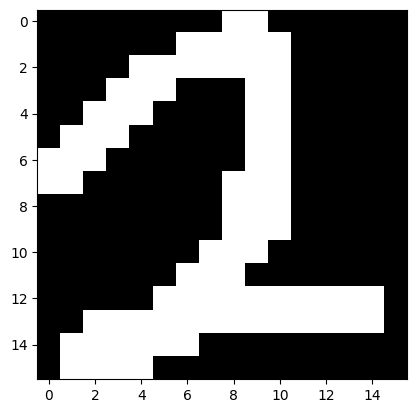

In [261]:
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)

if remove_border and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(20, 20)
elif not remove_border and not upscaled_images and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(28, 28)
elif downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(16, 16)
else:
    image = train_loader.dataset[random_index][0].reshape(32, 32)
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [7]:
# define first input and the name of the file to be saved
first_in_dim = 256 # 16x16
filename = "config/mnist_config_16x16.yaml"  

In [8]:
# reads the CSV file into a DataFrame
df = pd.read_csv("config/hyperparameters.csv")

# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_config_16x16.yaml' generated successfully.


#### Model Definition

DiffLogic Class

In [9]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        self.flatten = nn.Flatten()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        x = self.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs)

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [10]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### Model Training

In [38]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="aidays2024"):
    cfg = compose(config_name="mnist_config_16x16")

# training loop for all models
all_models_dict = {}
num_epochs = 5
file_path = 'trained_models/mnist_trained_16x16' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    try:
        # initializes DiffLogic model and moves to CUDA if available
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # optimizer and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        early_stopper = EarlyStopper(patience=5)

        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_loss = 0  # to track loss for an epoch
            
            for batch_inputs, batch_outputs in loop:
                # move data to the appropriate device
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

                # forward pass through the model
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)

                # zero gradients, backpropagates, and updates model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # accumulating the loss for the epoch
                epoch_loss += loss.item()

            # caclulating the average loss for the epoch
            epoch_loss /= len(train_loader)
            all_models_dict[model_name]['losses'].append(epoch_loss)
            print(f'Epoch {epoch+1} Loss: {epoch_loss}')

            # checks for early stopping
            if early_stopper.should_stop(epoch_loss):
                print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
                break

        # saving trained model's state
        model.save(file_path, model_name)

    except Exception as e:
        print(f"ERROR TRAINING {model_name.upper()}: {str(e)}")

print("All models processed.")

training model model_001
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/5: 100%|██████████| 211/211 [00:22<00:00,  9.21it/s]


Epoch 1 Loss: 1.1071626335269753


Epoch 2/5: 100%|██████████| 211/211 [00:14<00:00, 14.26it/s]


Epoch 2 Loss: 0.9123713733616494


Epoch 3/5: 100%|██████████| 211/211 [00:14<00:00, 14.26it/s]


Epoch 3 Loss: 0.9046454052842254


Epoch 4/5: 100%|██████████| 211/211 [00:14<00:00, 14.11it/s]


Epoch 4 Loss: 0.9015916291294143


Epoch 5/5: 100%|██████████| 211/211 [00:14<00:00, 14.21it/s]


Epoch 5 Loss: 0.8997698833029797
training model model_002
LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.82it/s]


Epoch 1 Loss: 0.7277596765956189


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.83it/s]


Epoch 2 Loss: 0.5037887632992861


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.78it/s]


Epoch 3 Loss: 0.493059557201373


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.84it/s]


Epoch 4 Loss: 0.48818752731915094


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.92it/s]


Epoch 5 Loss: 0.4851331331012353
training model model_003
LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.83it/s]


Epoch 1 Loss: 0.5773659256142976


Epoch 2/5: 100%|██████████| 211/211 [00:29<00:00,  7.22it/s]


Epoch 2 Loss: 0.3465081087152698


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.84it/s]


Epoch 3 Loss: 0.3317532907738154


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.88it/s]


Epoch 4 Loss: 0.3258479461154566


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.85it/s]


Epoch 5 Loss: 0.3229149752066505
training model model_004
LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.63it/s]


Epoch 1 Loss: 0.5112642140205919


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.67it/s]


Epoch 2 Loss: 0.28110635734063905


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.71it/s]


Epoch 3 Loss: 0.26207551448148836


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.57it/s]


Epoch 4 Loss: 0.2546728308666088


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.77it/s]


Epoch 5 Loss: 0.25036316303559825
training model model_005
LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.63it/s]


Epoch 1 Loss: 0.4772259098691571


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.64it/s]


Epoch 2 Loss: 0.2393370865664734


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.61it/s]


Epoch 3 Loss: 0.21738613219509054


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.61it/s]


Epoch 4 Loss: 0.20804596609884413


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.57it/s]


Epoch 5 Loss: 0.2028976527526424
training model model_006
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.56it/s]


Epoch 1 Loss: 1.0403675574365792


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.74it/s]


Epoch 2 Loss: 0.7354781981027435


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.76it/s]


Epoch 3 Loss: 0.7181438538582565


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.75it/s]


Epoch 4 Loss: 0.7101733114947205


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.78it/s]


Epoch 5 Loss: 0.7050680588058812
training model model_007
LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.53it/s]


Epoch 1 Loss: 0.7389157465892413


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.62it/s]


Epoch 2 Loss: 0.39205752861805016


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.56it/s]


Epoch 3 Loss: 0.37190324212089354


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.45it/s]


Epoch 4 Loss: 0.3624623004736834


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.57it/s]


Epoch 5 Loss: 0.3562939648795453
training model model_008
LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.36it/s]


Epoch 1 Loss: 0.6471036911562951


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.38it/s]


Epoch 2 Loss: 0.2771278494740178


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.30it/s]


Epoch 3 Loss: 0.25344851307354577


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.38it/s]


Epoch 4 Loss: 0.2432162326529094


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.34it/s]


Epoch 5 Loss: 0.2372562468608288
training model model_009
LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 13.05it/s]


Epoch 1 Loss: 0.5902198738087201


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.90it/s]


Epoch 2 Loss: 0.21986606672979075


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 13.11it/s]


Epoch 3 Loss: 0.1929491089796372


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 13.06it/s]


Epoch 4 Loss: 0.18165424794622378


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 13.08it/s]


Epoch 5 Loss: 0.17489599342055442
training model model_010
LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 12.90it/s]


Epoch 1 Loss: 0.5543212916954376


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.87it/s]


Epoch 2 Loss: 0.1821147016022453


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 12.86it/s]


Epoch 3 Loss: 0.15279300987046018


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 12.74it/s]


Epoch 4 Loss: 0.14065359075728875


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 12.91it/s]


Epoch 5 Loss: 0.13394507636130815
training model model_011
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.60it/s]


Epoch 1 Loss: 1.107700577762853


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.55it/s]


Epoch 2 Loss: 0.6895795155944766


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.55it/s]


Epoch 3 Loss: 0.6642489980016755


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.54it/s]


Epoch 4 Loss: 0.6512938146443163


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.59it/s]


Epoch 5 Loss: 0.6432425221065231
training model model_012
LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.23it/s]


Epoch 1 Loss: 0.8299987668450499


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 13.05it/s]


Epoch 2 Loss: 0.36792164510063213


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.23it/s]


Epoch 3 Loss: 0.34094333174823527


Epoch 4/5: 100%|██████████| 211/211 [00:15<00:00, 13.23it/s]


Epoch 4 Loss: 0.32886944253328926


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.20it/s]


Epoch 5 Loss: 0.321553302856818
training model model_013
LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 12.89it/s]


Epoch 1 Loss: 0.7159464222290504


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.81it/s]


Epoch 2 Loss: 0.25245925040988043


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 12.85it/s]


Epoch 3 Loss: 0.22513515152955232


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 12.65it/s]


Epoch 4 Loss: 0.21266153207886845


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 12.81it/s]


Epoch 5 Loss: 0.20557982996222735
training model model_014
LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 12.51it/s]


Epoch 1 Loss: 0.6945468597534946


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.47it/s]


Epoch 2 Loss: 0.20669081036554976


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 12.54it/s]


Epoch 3 Loss: 0.17555117864156752


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 12.53it/s]


Epoch 4 Loss: 0.16261718261615196


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 12.53it/s]


Epoch 5 Loss: 0.15452088948659712
training model model_015
LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/5: 100%|██████████| 211/211 [00:17<00:00, 12.05it/s]


Epoch 1 Loss: 0.6850369071232084


Epoch 2/5: 100%|██████████| 211/211 [00:17<00:00, 12.10it/s]


Epoch 2 Loss: 0.17697031908502986


Epoch 3/5: 100%|██████████| 211/211 [00:17<00:00, 12.12it/s]


Epoch 3 Loss: 0.14349617573499432


Epoch 4/5: 100%|██████████| 211/211 [00:17<00:00, 12.13it/s]


Epoch 4 Loss: 0.12949395844610428


Epoch 5/5: 100%|██████████| 211/211 [00:17<00:00, 12.10it/s]


Epoch 5 Loss: 0.1211624980792269
training model model_016
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/5: 100%|██████████| 211/211 [00:15<00:00, 13.29it/s]


Epoch 1 Loss: 1.228172032288914


Epoch 2/5: 100%|██████████| 211/211 [00:15<00:00, 13.21it/s]


Epoch 2 Loss: 0.716957827089307


Epoch 3/5: 100%|██████████| 211/211 [00:15<00:00, 13.25it/s]


Epoch 3 Loss: 0.6852948094169158


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 13.10it/s]


Epoch 4 Loss: 0.6700928061067425


Epoch 5/5: 100%|██████████| 211/211 [00:15<00:00, 13.25it/s]


Epoch 5 Loss: 0.6604141478587785
training model model_017
LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 12.79it/s]


Epoch 1 Loss: 0.950762397514278


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.82it/s]


Epoch 2 Loss: 0.38162189943826397


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 12.81it/s]


Epoch 3 Loss: 0.348355997241521


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 12.81it/s]


Epoch 4 Loss: 0.33221871526268265


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 12.78it/s]


Epoch 5 Loss: 0.32203294720931697
training model model_018
LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/5: 100%|██████████| 211/211 [00:17<00:00, 12.14it/s]


Epoch 1 Loss: 0.9100649959698093


Epoch 2/5: 100%|██████████| 211/211 [00:17<00:00, 12.32it/s]


Epoch 2 Loss: 0.2786706938102599


Epoch 3/5: 100%|██████████| 211/211 [00:17<00:00, 12.26it/s]


Epoch 3 Loss: 0.24477639333737536


Epoch 4/5: 100%|██████████| 211/211 [00:17<00:00, 12.31it/s]


Epoch 4 Loss: 0.22937154983531746


Epoch 5/5: 100%|██████████| 211/211 [00:17<00:00, 12.28it/s]


Epoch 5 Loss: 0.2201257256874478
training model model_019
LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/5: 100%|██████████| 211/211 [00:17<00:00, 11.81it/s]


Epoch 1 Loss: 0.8583802726815382


Epoch 2/5: 100%|██████████| 211/211 [00:17<00:00, 11.80it/s]


Epoch 2 Loss: 0.22335065914042046


Epoch 3/5: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


Epoch 3 Loss: 0.18780447740070802


Epoch 4/5: 100%|██████████| 211/211 [00:17<00:00, 11.80it/s]


Epoch 4 Loss: 0.17159176773179596


Epoch 5/5: 100%|██████████| 211/211 [00:17<00:00, 11.81it/s]


Epoch 5 Loss: 0.16265697334734472
training model model_020
LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/5: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


Epoch 1 Loss: 0.844553087771118


Epoch 2/5: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


Epoch 2 Loss: 0.19511965885481314


Epoch 3/5: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


Epoch 3 Loss: 0.15654137370356894


Epoch 4/5: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


Epoch 4 Loss: 0.1402476656539027


Epoch 5/5: 100%|██████████| 211/211 [00:27<00:00,  7.80it/s]


Epoch 5 Loss: 0.13036167520282063
training model model_021
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/5: 100%|██████████| 211/211 [00:16<00:00, 12.42it/s]


Epoch 1 Loss: 1.5313870869726796


Epoch 2/5: 100%|██████████| 211/211 [00:16<00:00, 12.98it/s]


Epoch 2 Loss: 0.8923614198556652


Epoch 3/5: 100%|██████████| 211/211 [00:16<00:00, 13.01it/s]


Epoch 3 Loss: 0.8374500448240496


Epoch 4/5: 100%|██████████| 211/211 [00:16<00:00, 13.00it/s]


Epoch 4 Loss: 0.8076473342949071


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 13.00it/s]


Epoch 5 Loss: 0.7904931443307684
training model model_022
LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/5: 100%|██████████| 211/211 [00:17<00:00, 12.18it/s]


Epoch 1 Loss: 1.2824984373247412


Epoch 2/5: 100%|██████████| 211/211 [00:17<00:00, 12.39it/s]


Epoch 2 Loss: 0.5006221354397777


Epoch 3/5: 100%|██████████| 211/211 [00:17<00:00, 12.35it/s]


Epoch 3 Loss: 0.4479044468223437


Epoch 4/5: 100%|██████████| 211/211 [00:17<00:00, 12.41it/s]


Epoch 4 Loss: 0.42308343330096776


Epoch 5/5: 100%|██████████| 211/211 [00:16<00:00, 12.42it/s]


Epoch 5 Loss: 0.40842856330231747
training model model_023
LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/5: 100%|██████████| 211/211 [00:17<00:00, 11.76it/s]


Epoch 1 Loss: 1.2195165600682658


Epoch 2/5: 100%|██████████| 211/211 [00:17<00:00, 11.76it/s]


Epoch 2 Loss: 0.36946583110444187


Epoch 3/5: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


Epoch 3 Loss: 0.31861297106201575


Epoch 4/5: 100%|██████████| 211/211 [00:17<00:00, 11.75it/s]


Epoch 4 Loss: 0.29514725964812744


Epoch 5/5: 100%|██████████| 211/211 [00:17<00:00, 11.77it/s]


Epoch 5 Loss: 0.28119275797224635
training model model_024
LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/5: 100%|██████████| 211/211 [00:18<00:00, 11.26it/s]


Epoch 1 Loss: 1.1678263858811


Epoch 2/5: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


Epoch 2 Loss: 0.2997436573249081


Epoch 3/5: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


Epoch 3 Loss: 0.2471662845415092


Epoch 4/5: 100%|██████████| 211/211 [00:18<00:00, 11.31it/s]


Epoch 4 Loss: 0.22398885224153398


Epoch 5/5: 100%|██████████| 211/211 [00:18<00:00, 11.17it/s]


Epoch 5 Loss: 0.20999805383483142
training model model_025
LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/5: 100%|██████████| 211/211 [00:19<00:00, 10.64it/s]


Epoch 1 Loss: 1.181439204564553


Epoch 2/5: 100%|██████████| 211/211 [00:19<00:00, 10.70it/s]


Epoch 2 Loss: 0.26663857667887647


Epoch 3/5: 100%|██████████| 211/211 [00:19<00:00, 10.64it/s]


Epoch 3 Loss: 0.2093386595166547


Epoch 4/5: 100%|██████████| 211/211 [00:19<00:00, 10.68it/s]


Epoch 4 Loss: 0.18454287616279527


Epoch 5/5: 100%|██████████| 211/211 [00:19<00:00, 10.68it/s]


Epoch 5 Loss: 0.1709406699354489
All models processed.


#### Model Testing

In [48]:
# testing loop to test inferences
trained_models_dir = 'trained_models/mnist_trained_16x16'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="mnist_config_16x16")

# dictionary to store the trained models
trained_models = {}
trained_models_accuracies = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    
    model_cfg = cfg['models'][model_name]
    
    # instantiates the model and load its weights
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_path = os.path.join(trained_models_dir, model_file)
    print(f"Evaluating {model_file}...")

    # loads the respective model
    model.load(model_path)
    
    # calculates accuracy
    accuracy = model.get_accuracy(test_loader)
    
    print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")
    
    trained_models[i] = model
    trained_models_accuracies[i] = accuracy

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Accuracy of model_001.pth: 84.75%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_002.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.50it/s]


Accuracy of model_002.pth: 89.58%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_003.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.48it/s]


Accuracy of model_003.pth: 92.38%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_004.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.48it/s]


Accuracy of model_004.pth: 93.57%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_005.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.52it/s]


Accuracy of model_005.pth: 94.24%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_006.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.58it/s]


Accuracy of model_006.pth: 87.18%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_007.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.60it/s]


Accuracy of model_007.pth: 92.05%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_008.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.62it/s]


Accuracy of model_008.pth: 94.04%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_009.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.58it/s]


Accuracy of model_009.pth: 94.92%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_010.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.63it/s]


Accuracy of model_010.pth: 95.65%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_011.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.67it/s]


Accuracy of model_011.pth: 87.58%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_012.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.66it/s]


Accuracy of model_012.pth: 92.69%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_013.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.54it/s]


Accuracy of model_013.pth: 94.63%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_014.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.42it/s]


Accuracy of model_014.pth: 95.30%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_015.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.45it/s]


Accuracy of model_015.pth: 95.81%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_016.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.60it/s]


Accuracy of model_016.pth: 87.70%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_017.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.48it/s]


Accuracy of model_017.pth: 92.50%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_018.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]


Accuracy of model_018.pth: 94.35%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_019.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.35it/s]


Accuracy of model_019.pth: 95.09%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_020.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.39it/s]


Accuracy of model_020.pth: 95.73%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_021.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.53it/s]


Accuracy of model_021.pth: 84.70%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_022.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.44it/s]


Accuracy of model_022.pth: 90.67%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_023.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.39it/s]


Accuracy of model_023.pth: 92.73%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_024.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.28it/s]


Accuracy of model_024.pth: 94.34%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_025.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]

Accuracy of model_025.pth: 94.93%



#### Verilog Conversion

Logic gate to Verilog expression mapping

In [40]:
logic_gate_verilog = {
    "0": "1'b0",
    "A∧B": "({a}) & ({b})",
    "¬(A⇒B)": "({a}) & ~({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) & ~({a})",
    "B": "{b}",
    "A⊕B": "({a}) ^ ({b})",
    "A∨B": "({a}) | ({b})",
    "¬(A∨B)": "~(({a}) | ({b}))",
    "¬(A⊕B)": "~(({a}) ^ ({b}))",
    "¬B": "~({b})",
    "B⇒A": "~({b}) | ({a})",
    "¬A": "~({a})",
    "A⇒B": "~({a}) | ({b})",
    "¬(A∧B)": "~(({a}) & ({b}))",
    "1": "1'b1"
}

In [41]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# converts the learned logic gates to verilog or vhdl 
def generate_verilog(model, filename="logic_network.v"):
    
    N_layers = len(model.logic_layers)

    # gets number of neurons per layer
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]
    
    # Set the output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # module declaration
        file.write("module logic_network(\n")
        file.write(f"    input wire [{N_input-1}:0] inputs,\n")
        file.write(f"    output wire [{N_output-1}:0] outputs\n")
        file.write(");\n\n")

        # declares wires for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    wire [{N_neurons -1}:0] layer{layer_index}_outputs;\n")
        file.write("\n")

        logic_operations = list(logic_gate_verilog.keys())

        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # gets input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # determines input wires
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # determines output wires
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # assign statements for this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # maps indices to input wires
                a_wire = f"{input_wire_base}[{a_idx}]"
                b_wire = f"{input_wire_base}[{b_idx}]"

                # gets gate
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_verilog[gate_op].format(a=a_wire, b=b_wire)

                # assigns to output wire
                output_wire = f"{output_wire_base}[{neuron_id}]"

                file.write(f"    assign {output_wire} = {gate};\n")

        file.write("endmodule\n")
        print('success')

# generates Verilog file for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_verilog(trained_models[model_idx], filename=f"verilog/{side}x{side}/model_{i:03d}_logic_network.v")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


#### VHDL Conversion

Logic gate to Verilog expression mapping

In [42]:
logic_gate_vhdl = {
    "0": "'0'",
    "A∧B": "({a}) and ({b})",
    "¬(A⇒B)": "({a}) and not ({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) and not ({a})",
    "B": "{b}",
    "A⊕B": "({a}) xor ({b})",
    "A∨B": "({a}) or ({b})",
    "¬(A∨B)": "not(({a}) or ({b}))",
    "¬(A⊕B)": "not(({a}) xor ({b}))",
    "¬B": "not({b})",
    "B⇒A": "not({b}) or ({a})",
    "¬A": "not({a})",
    "A⇒B": "not({a}) or ({b})",
    "¬(A∧B)": "not(({a}) and ({b}))",
    "1": "'1'"
}

In [43]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# Converts the learned logic gates to VHDL
def generate_vhdl(model, filename="logic_network.vhdl"):
    N_layers = len(model.logic_layers)
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]

    # set output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # Library and entity declaration
        file.write("library IEEE;\n")
        file.write("use IEEE.STD_LOGIC_1164.ALL;\n\n")
        file.write("entity logic_network is\n")
        file.write(f"    port (\n")
        file.write(f"        inputs : in std_logic_vector({N_input - 1} downto 0);\n")
        file.write(f"        outputs : out std_logic_vector({N_output - 1} downto 0)\n")
        file.write("    );\n")
        file.write("end logic_network;\n\n")
        file.write("architecture Behavioral of logic_network is\n")

        # Declare signals for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    signal layer{layer_index}_outputs : std_logic_vector({N_neurons - 1} downto 0);\n")
        file.write("\nbegin\n\n")

        logic_operations = list(logic_gate_vhdl.keys())

        # Generate VHDL code for each layer
        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # Get input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # Determine input signals
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # Determine output signals
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # Assign statements for each neuron in this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # Map indices to input signals
                a_wire = f"{input_wire_base}({a_idx})"
                b_wire = f"{input_wire_base}({b_idx})"

                # Get the gate operation
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_vhdl[gate_op].format(a=a_wire, b=b_wire)

                # Assign to output signal
                output_wire = f"{output_wire_base}({neuron_id})"
                file.write(f"    {output_wire} <= {gate};\n")

        file.write("\nend Behavioral;\n")
        print('success')

# Generates VHDL files for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_vhdl(trained_models[model_idx], filename=f"vhdl/{side}x{side}/model_{i:03d}_logic_network.vhdl")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


#### Predicting from Hex

Sanity check to see that the FPGA output matches the model predictions on the same data

In [49]:
import numpy as np
import re

def load_images_from_hex_file(filename):
    images = []
    hex_pattern = re.compile(r'^[0-9a-fA-F]+$')  # only allows valid hex characters

    with open(filename, 'r') as file:
        for line in file:
            if ':' in line:
                hex_data = line.split(':')[1].strip().strip(';')
                
                # check if hex_data is a valid hexadecimal string
                if hex_pattern.match(hex_data):
                    # convert to binary and pad to 256 bits
                    bin_data = bin(int(hex_data, 16))[2:].zfill(256)
                    image = np.array([int(bit) for bit in bin_data], dtype=np.uint8).reshape(16, 16)
                    images.append(image)
                else:
                    print(f"Skipping invalid line: {line.strip()}")

    return np.array(images)

# loading images
filename = 'mnist_input.mif'  
images = load_images_from_hex_file(filename)

In [53]:
def run_inference_on_images(model, images):
    model.eval()  # sets model to evaluation mode
    predictions = []
    
    # starts inference time
    start_time = time.time()
    
    for img in images:
        # flatten each 16x16 image to a 1D tensor with 256 elements
        input_data = torch.tensor(img.flatten(), dtype=torch.float32).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        with torch.no_grad():  # disable gradient computation for inference
            output = model(input_data)
            _, predicted_label = torch.max(output, 1)  # get the predicted label
            predictions.append(predicted_label.item())
    
    # end timing inference
    end_time = time.time()
    inference_time = end_time - start_time  # total inference time in seconds
    avg_inference_time = inference_time / len(images)
    
    return predictions, avg_inference_time

# dictionary to store the predictions and avg inference times for each of the 25 models    
predictions = {}
avg_inference_times = {}

for model_idx in trained_models:
    prediction, avg_inference_time = run_inference_on_images(trained_models[model_idx], images)
    predictions[model_idx] = prediction
    avg_inference_times[model_idx] = avg_inference_time

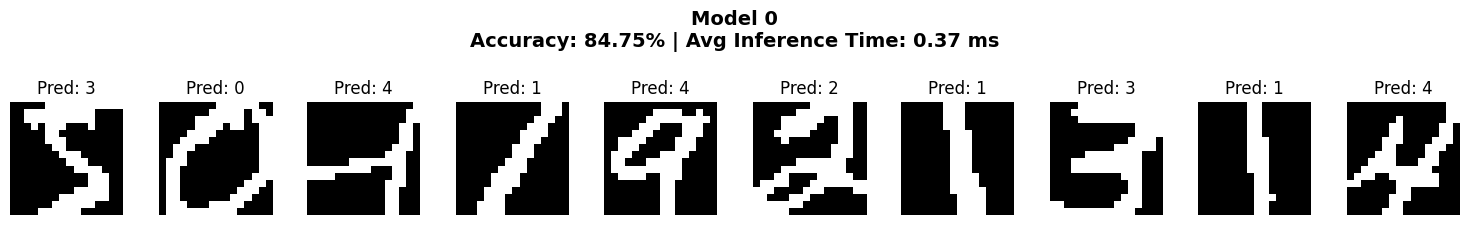

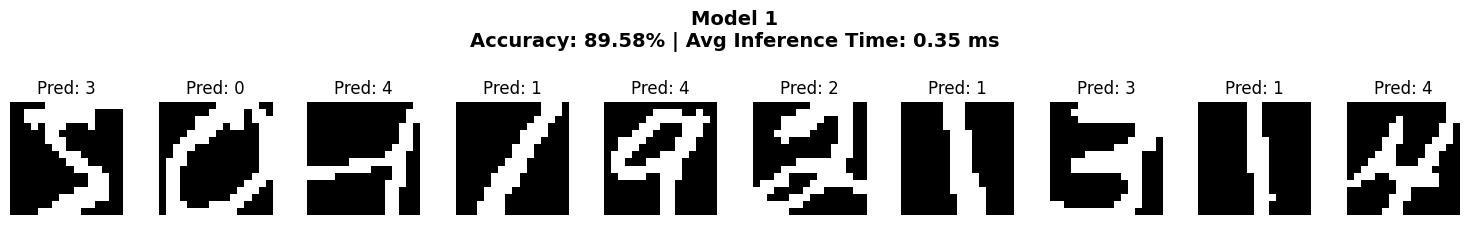

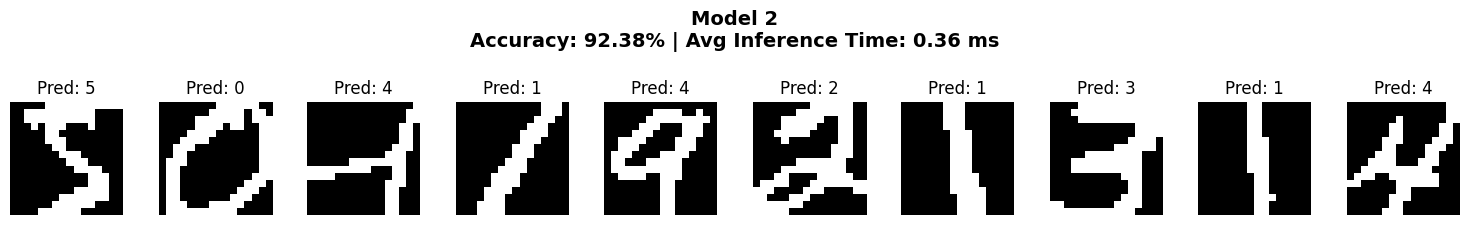

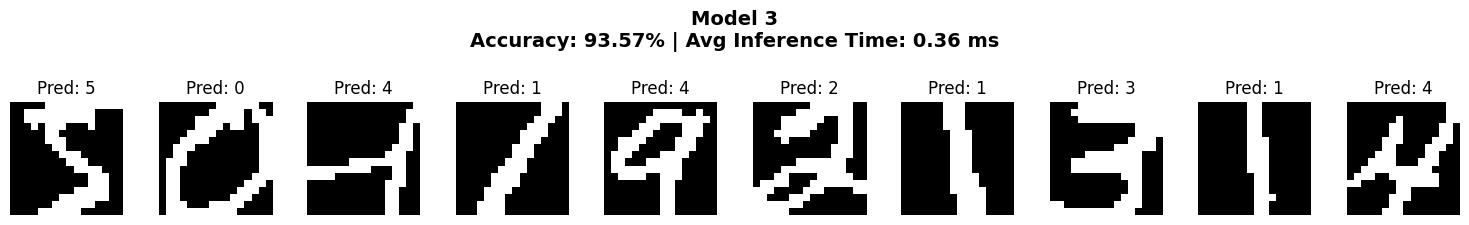

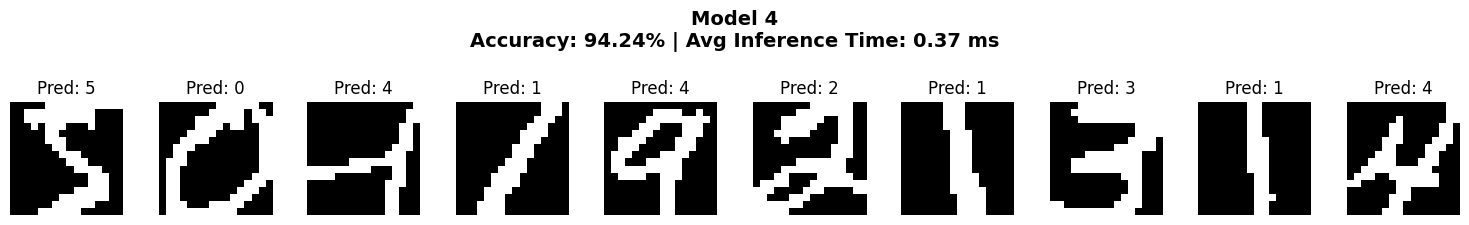

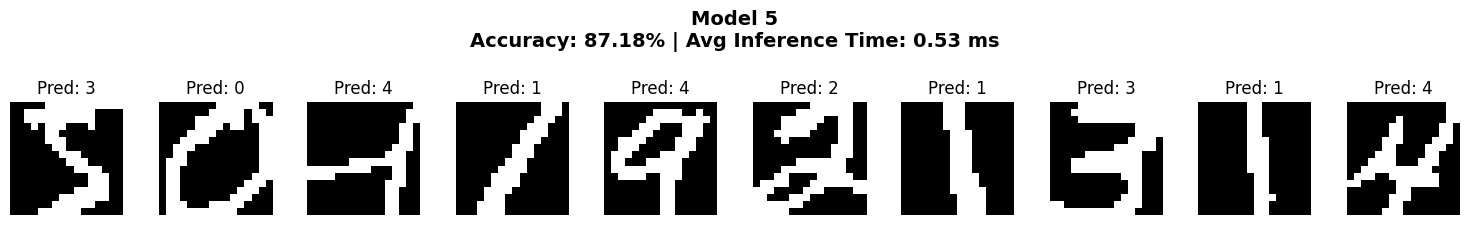

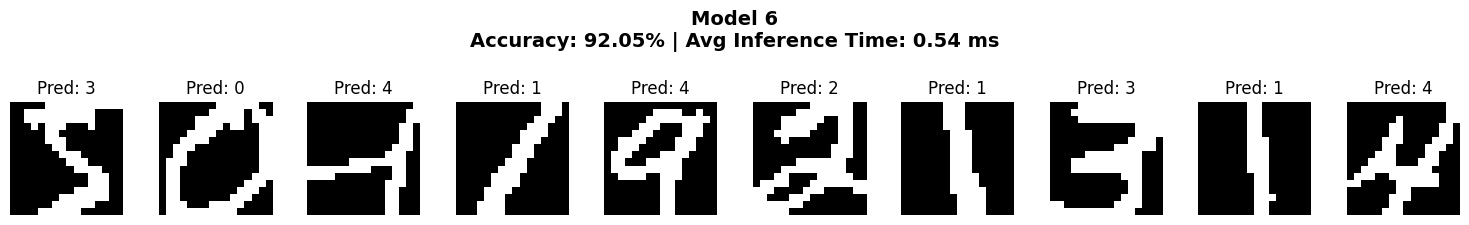

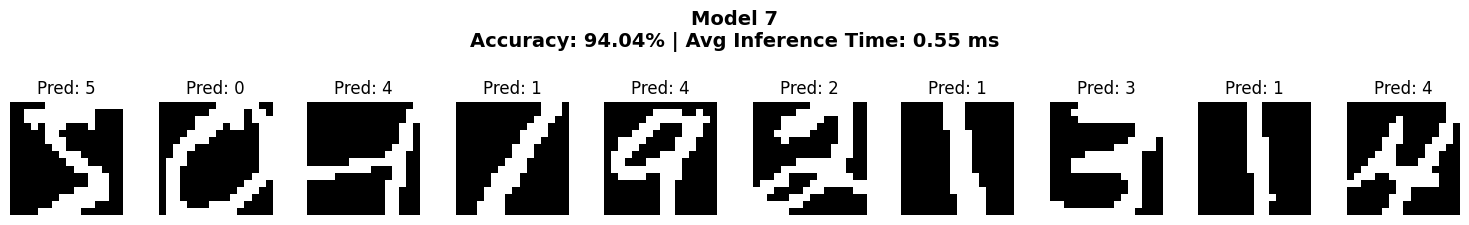

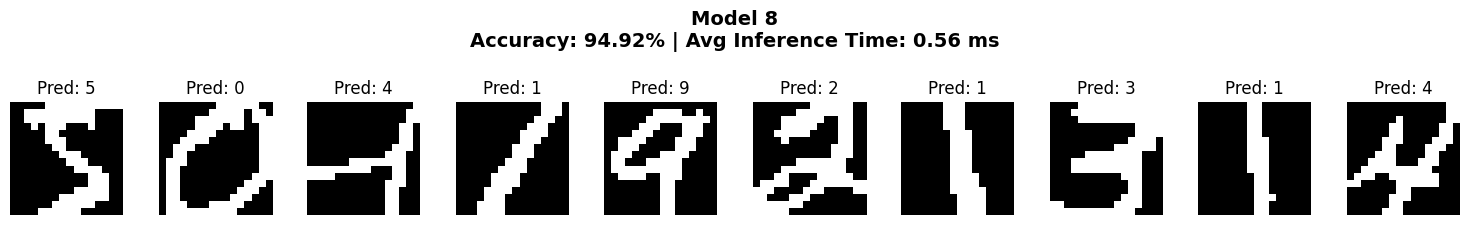

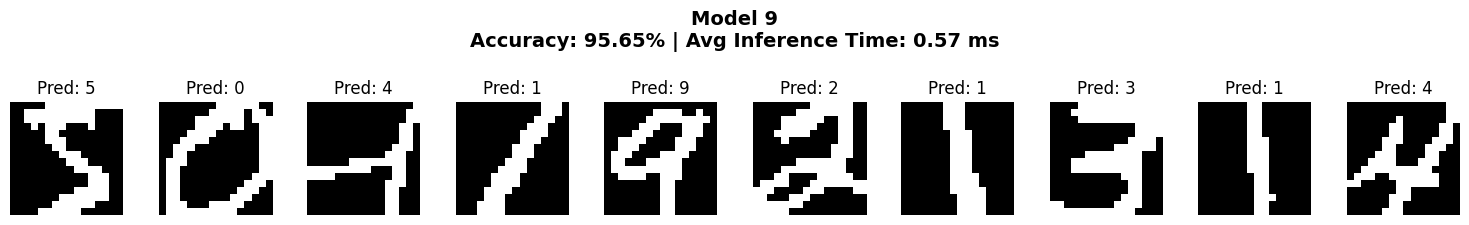

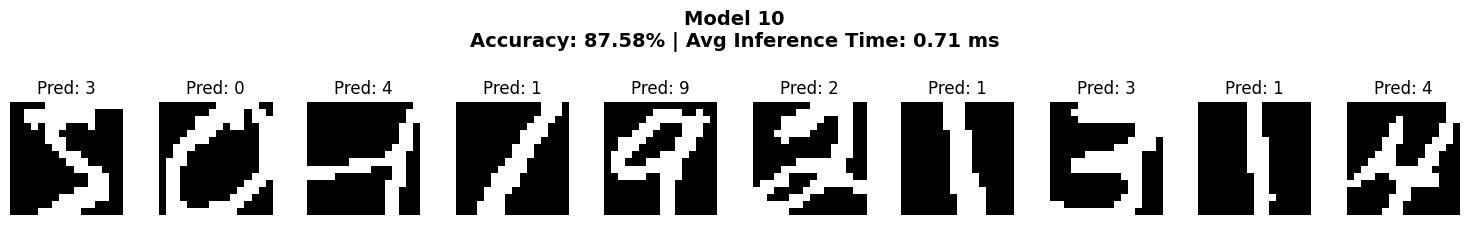

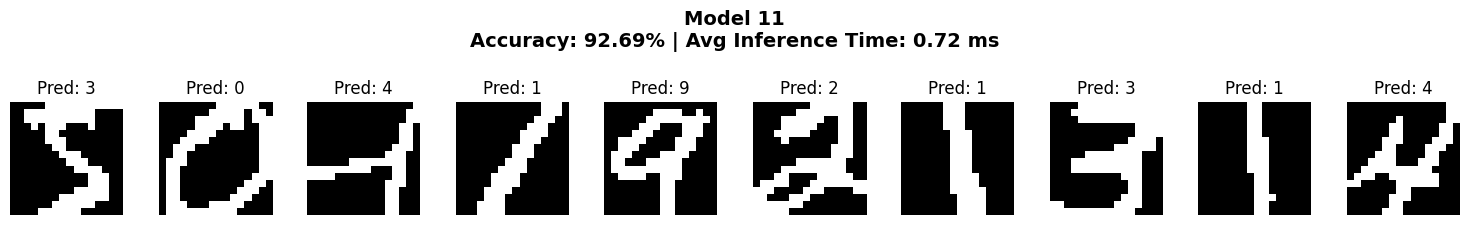

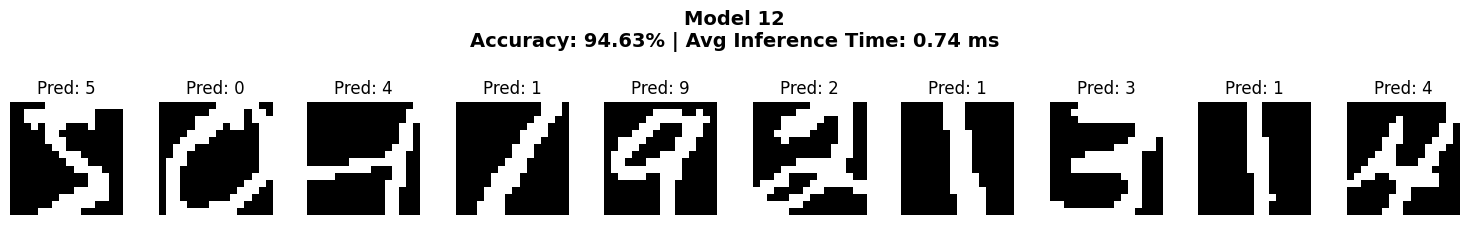

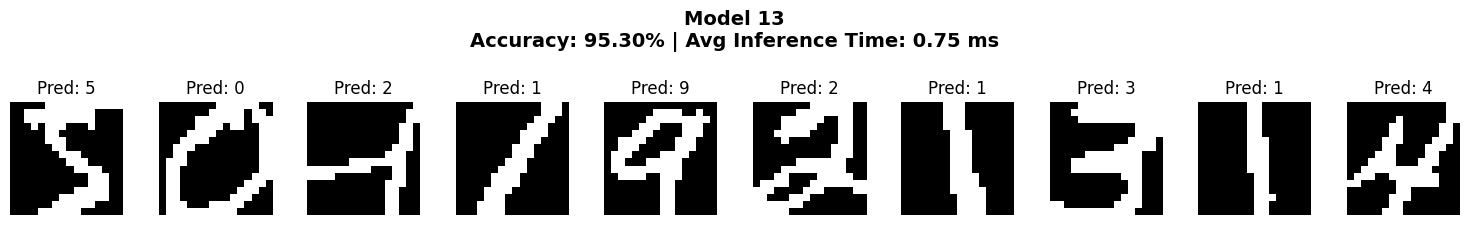

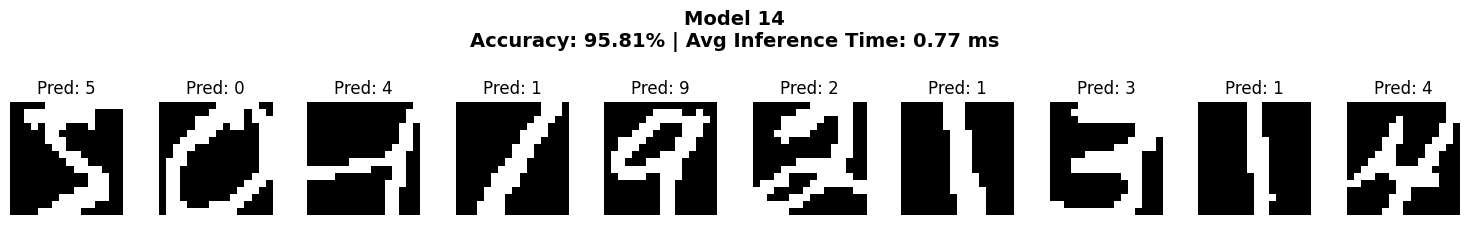

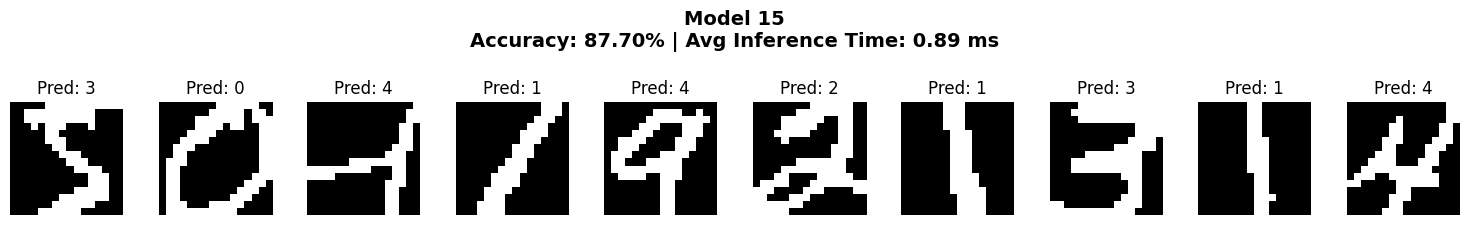

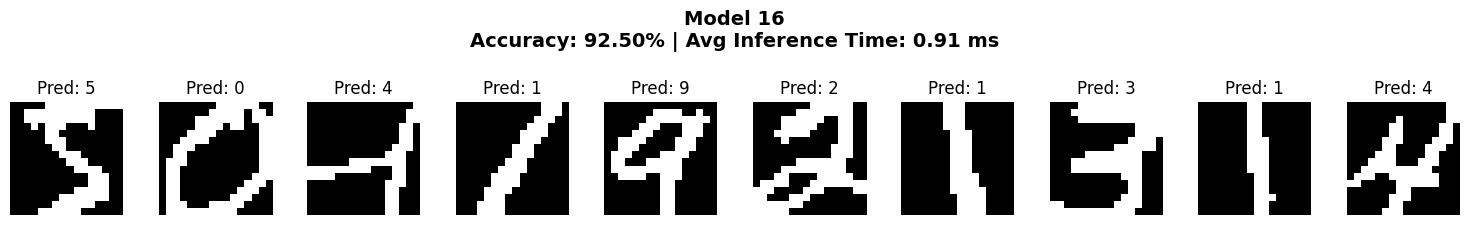

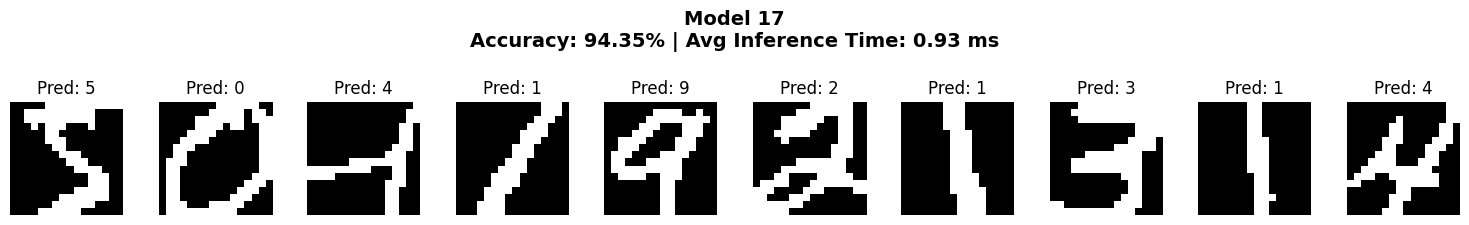

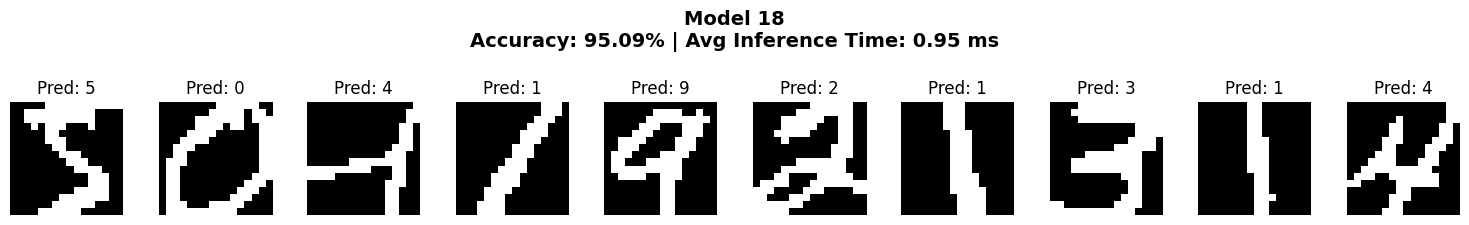

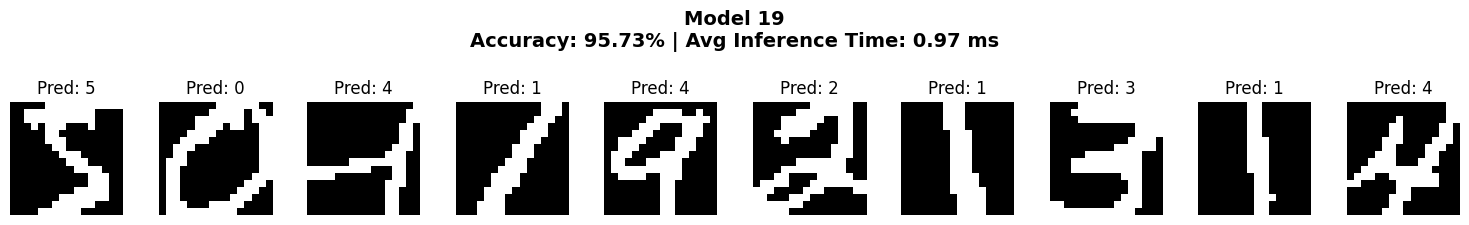

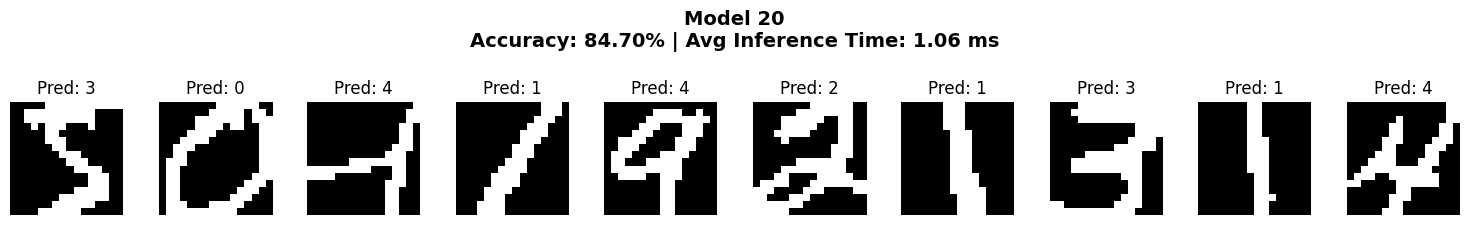

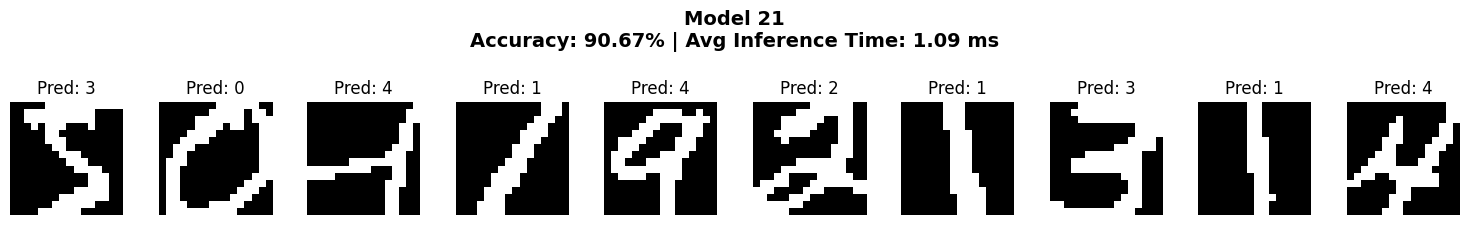

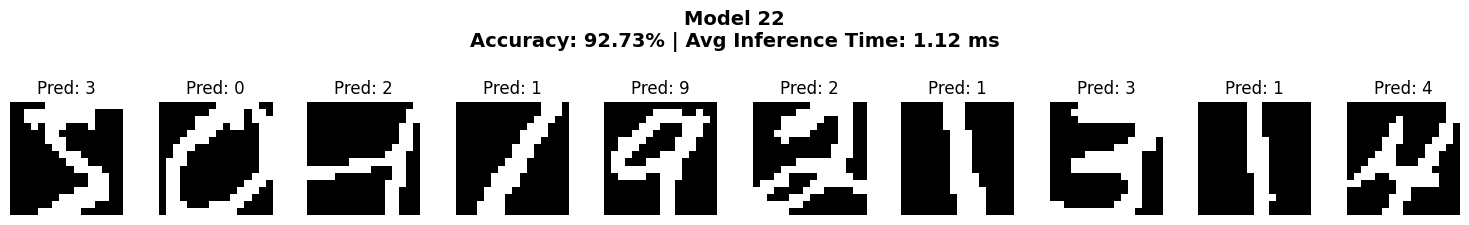

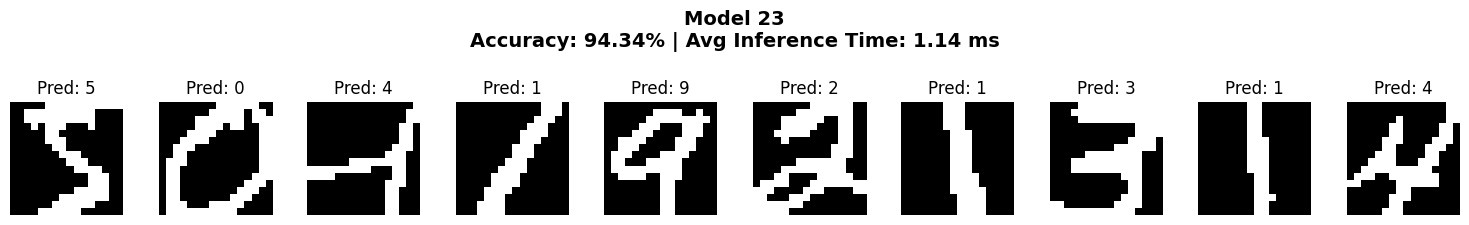

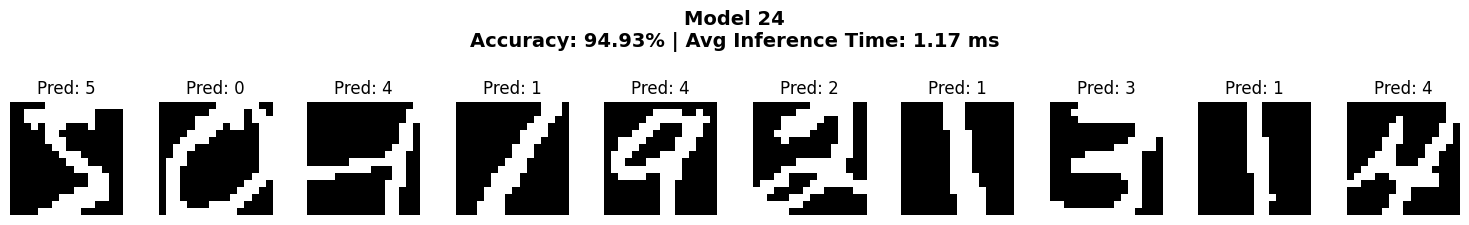

In [66]:
# displays some sample images with predictions
def display_images_side_by_side(images, predictions, num_images=10, title="Model", accuracy=None, avg_inference_time=None):
    
    # converts avg_inference_time from seconds to milliseconds
    avg_inference_time_ms = avg_inference_time * 1000 if avg_inference_time is not None else 0
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))  
    
    # sets big title above all images with accuracy and inference time
    fig.suptitle(f"{title}\nAccuracy: {accuracy:.2%} | Avg Inference Time: {avg_inference_time_ms:.2f} ms", 
                 fontsize=14, fontweight='bold', y=1.1)
    
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Pred: {predictions[i]}")
        axes[i].axis('off')  
    
    plt.tight_layout()
    plt.show()

# loops through each model and display images with respective accuracy and inference time
for model_name, preds in predictions.items():
    # gets accuracy and inference time for the current model
    accuracy = trained_models_accuracies[model_name]
    avg_inference_time = avg_inference_times[model_name]
    # displaying the first 10 images side by side with their predictions
    display_images_side_by_side(
        images, preds, num_images=10, 
        title=f'Model {model_name}', 
        accuracy=accuracy, 
        avg_inference_time=avg_inference_time
    )